In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from sklearn.utils import resample

sns.set()
%matplotlib inline

endangered_languages = pd.read_csv('../data_sets/endangered_languages_ML.csv')
X = endangered_languages.drop(['Language', 'Extinct'], axis=1)
y = endangered_languages['Extinct']
print(X.shape)
print(y.shape)

(1933, 160)
(1933,)


Class 0: 1740
Class 1: 193
Proportion: 9.02 : 1


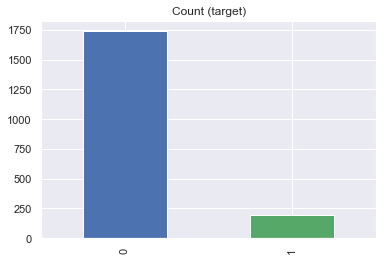

In [2]:
target_count = y.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)', color=['b', 'g']);

I know that from intimate knowledge of my dataset that my classes are imbalanced. Taking a look at the graph, we can see that the number of extinct languages is small compared to the number of non-extinct languages. Approximately a 9 to 1 imbalance. So we can do some data resampling to correct this issue before running any models on the data.

One of the major issues with this not being handled is that any simple metrics used to evaluate the model can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate.

In [3]:
# Class count
class_count_0, class_count_1 = target_count

# Divide by class
df_class_0 = y[y == 0]
df_class_1 = y[y == 1]

#### Random Under-Sampling

1    193
0    193
Name: Extinct, dtype: int64


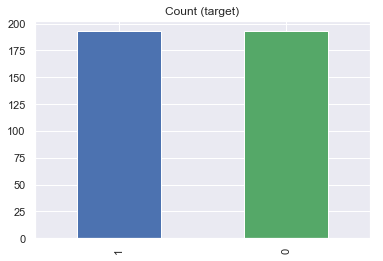

In [4]:
df_class_0_under = df_class_0.sample(class_count_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print(df_test_under.value_counts())

df_test_under.value_counts().plot(kind='bar', title='Count (target)', color=['b', 'g']);

#### Random Over-Sampling

1    1740
0    1740
Name: Extinct, dtype: int64


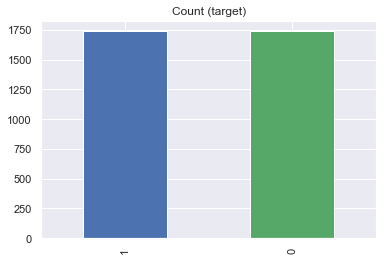

In [5]:
df_class_1_over = df_class_1.sample(class_count_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print(df_test_over.value_counts())

df_test_over.value_counts().plot(kind='bar', title='Count (target)', color=['b', 'g']);

In [6]:
# A number of more sophisticated resampling techniques have been proposed in the scientific literature.

# For example, we can cluster the records of the majority class, and do the under-sampling by removing records from 
# each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority 
# class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

# Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with 
# scikit-learn and is part of scikit-learn-contrib projects.

We will also create a 2-dimensional plot function, plot_2d_space, to see the data distribution, because the dataset has many dimensions (features) and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA):

In [7]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y == l, 0],
            X[y == l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

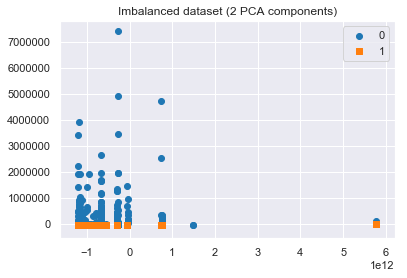

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_2d_space(X_pca, y, 'Imbalanced dataset (2 PCA components)')

Let's now train a model with balanced data

In [9]:
df_majority = endangered_languages[endangered_languages['Extinct'] == 0]
df_minority = endangered_languages[endangered_languages['Extinct'] == 1]

# Up-sampling is the process of randomly duplicating observations from the minority class 
# in order to reinforce its signal.

# There are several heuristics for doing so, but the most common way is to simply resample with replacement.
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                  replace=True,     # sample with replacement
                                  n_samples=1740,    # to match majority class
                                  random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['Extinct'].value_counts()

1    1740
0    1740
Name: Extinct, dtype: int64

In [10]:
log_reg = LogisticRegression(solver='lbfgs')

In [11]:
X = df_upsampled.drop(['Language', 'Extinct'], axis=1)
y = df_upsampled['Extinct']
print(X.shape)
print(y.shape)

(3480, 160)
(3480,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [13]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print(np.unique(y_pred))

# How's our accuracy now?
print(accuracy_score(y_test, y_pred))

[1]
0.514367816091954


While the accuracy seems about right, our model is only predicting class 1. Which means it's completely ignoring the non-extinct langauge class in favor of the extinct class. This may be due to upsampling which as I said above duplicates the minority class to reinforce it's signal. I'll try downsampling next, with hopes of a better accuracy score.

In [15]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=193,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['Extinct'].value_counts()

1    193
0    193
Name: Extinct, dtype: int64

In [16]:
X = df_downsampled.drop(['Language', 'Extinct'], axis=1)
y = df_downsampled['Extinct']
print(X.shape)
print(y.shape)

(386, 160)
(386,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [18]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print(np.unique(y_pred))

# How's our accuracy now?
print(accuracy_score(y_test, y_pred))

[1]
0.5775862068965517


The downsampled data recieved a better accuracy score, but still is misleading as the model once again only predicts 1 class. Let's see if standardizing the data before downsampling helps. Using RobustScaler, I will attempt to minimize the effect of outliers.

In [43]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler(quantile_range=(25, 75))
col_names = endangered_languages.columns

col_list = list(col_names)
col_list.pop(0)

X = endangered_languages.drop(['Language'], axis=1)

scaled_langauges = scaler.fit_transform(X)

scaled_df = pd.DataFrame(scaled_langauges, columns=col_list)

scaled_df.shape

(1933, 161)

In [44]:
df_majority = scaled_df[scaled_df['Extinct'] == 0]
df_minority = scaled_df[scaled_df['Extinct'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=193,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['Extinct'].value_counts()

1.0    193
0.0    193
Name: Extinct, dtype: int64

In [46]:
X = df_downsampled.drop(['Extinct'], axis=1)
y = df_downsampled['Extinct']
print(X.shape)
print(y.shape)

(386, 160)
(386,)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [48]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print(np.unique(y_pred))

# How's our accuracy now?
print(accuracy_score(y_test, y_pred))

[0. 1.]
0.9913793103448276


The model's accuracy jumped through the roof! It's not predicting just one class anymore. Let's look at a confusion matrix to get a better idead of how the model is performing

In [49]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[49  0]
 [ 1 66]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        49
         1.0       1.00      0.99      0.99        67

   micro avg       0.99      0.99      0.99       116
   macro avg       0.99      0.99      0.99       116
weighted avg       0.99      0.99      0.99       116



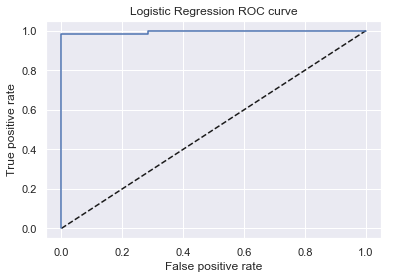

In [50]:
# ROC Curve (threshold is 0.5 for probability (this threshold defines our model), what happens when we vary threshold. 
# What happens to the true positive and false positive rates. WHen threshold = 0, the model predicts 1 for all data
# which means the true positive is equal to false positve) 0 and 1 are bad should go straight up and then right
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.show()

In [52]:
# the larger the area under the ROC curve, the better our model is
roc_auc_score(y_test, y_pred_prob)

# can also be done with cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc')
print(cv_scores)

[1. 1. 1. 1. 1.]


In [54]:
# Hyperparameter tuning with GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(log_reg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Tuned Logistic Regression Parameters: {'C': 3.727593720314938}
Best score is 1.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

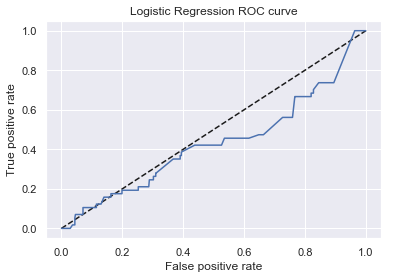

In [34]:
# ROC Curve (threshold is 0.5 for probability (this threshold defines our model), what happens when we vary threshold. 
# What happens to the true positive and false positive rates. WHen threshold = 0, the model predicts 1 for all data
# which means the true positive is equal to false positve) 0 and 1 are bad should go straight up and then right
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.show()

In [40]:
# the larger the area under the ROC curve, the better our model is
roc_auc_score(y_test, y_pred_prob)

# can also be done with cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
print(cv_scores)

[0.43918326 0.41507286 0.37425697 0.50518214 0.49992379]


In [44]:
# Hyperparameter tuning with GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(log_reg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X_train, y_train.values.ravel())

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1e-05}
Best score is 0.8994826311899483


In [ ]:
# Hold out test reasoning
# upsample all data
# random forest classification 
# knn 
# logisitic regression

# upsample 
# duplicate extinct langaue rows
# SMOTE (has random permutations to data)
# predict_proba(with threshold adjustment away from 50%)